# Asset-Level Annual Temperature From CMIP6

## Dataset and Specifications

Here we extract CMIP6 annual temperature for given asset locations. The current setup reads raw monthly temperature values from a Pangeo Google Cloud Platform hosting much of the CMIP6 data and aggregates to annual mean temperatures. This is quite slow, roughly 70 seconds per model with at least 27 models available. Ultimately we should instead produce an ensemble average temperature file with complete global coverage, a time consuming process, and then query that as needed with asset coordinates.

The raw temperature values are in Kelvin but are converted to Celsius here before export as annual mean temperature. 


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gcsfs 
import xarray as xr 
import zarr # Note: 'pip install zarr' tends to fail, but conda works
import intake 
import time 
import matplotlib.pyplot as plt

In [ ]:
from dask.distributed import Client
from dask_gateway import Gateway

gateway = Gateway()
cluster = gateway.new_cluster()
cluster.scale(20)
cluster

In [ ]:
client = Client(cluster)
client

# Some Settings

In [4]:
ENTITY_NAME = 'MRTG.A'
BASE_DATA_FOLDER = '../data/'
historical_experiment_id = 'historical'
future_experiment_id = 'ssp585'
start_year = 1980 
end_year = 2100
q_lbd = 0.15 # Quantile bounds for uncertainty analysis
q_ubd = 0.85
max_runs = 10 # Max runs to include per climate model. Reduce to run faster. Most have 5 runs or fewer.
variable_id = 'tas' # tas = temperature at surface [Kelvin]
table_id = 'Amon' #Amon = Atmosphere, monthly 

In [3]:
#### CUT Lines below on upload to docker
os.getcwd()
os.chdir('/Users/tristanballard/Sources/geoexplorer/jupyter-notebooks/')

# Inspect Entity Asset Dataset

In [5]:
df_asset = pd.read_csv(BASE_DATA_FOLDER + 'sust/'+ ENTITY_NAME + '_combined_locations.csv')
print(df_asset.head(3))
lats = xr.DataArray(df_asset['lat'], dims = 'z')
lons = xr.DataArray(df_asset['lng'], dims = 'z')

                                             Address  \
0            6060 Electron Dr., Anchorage, AK, 99518   
1             1901 Airport Way, Fairbanks, AK, 99701   
2  4510 Old International Airport Rd 99502, Ancho...   

                                                 url       Price    Lot Size  \
0  http://www.loopnet.com/Listing/20157634/6060-E...  10239431.0  680,276 SF   
1  http://www.loopnet.com/Listing/18499430/1901-A...   4050000.0     3.26 AC   
2  http://www.loopnet.com/Listing/20000996/4510-O...   3500000.0     1.09 AC   

     Type        lat         lng               h3 state  
0    Land  61.166342 -149.903095  860c73387ffffff    AK  
1  Office  64.836688 -147.759048  860d5a9afffffff    AK  
2  Office  61.174249 -149.974253  860c73387ffffff    AK  


# Read in csv of currently available CMIP6 data on Pangeo GCP


In [6]:
df_cmip = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_cmip.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,AerChemMIP,AS-RCEC,TaiESM1,histSST,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/AerChemMIP/AS-RCEC/TaiESM1/histSST/...,NaN,20200310
1,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrbc,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190718
2,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrdust,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127
3,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmroa,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190809
4,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrso4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127


# Filter out models by variable of interest and CMIP experiment

In [7]:
experiment_id = [historical_experiment_id, future_experiment_id]

df_cmip = df_cmip[(df_cmip['table_id'] == table_id) & 
                (df_cmip['variable_id'] == variable_id) & 
                (df_cmip['experiment_id'].isin(experiment_id)) &
                (df_cmip['grid_label'].isin(['gn', 'gr', 'gr1']))]
print(df_cmip.head(3))

     activity_id institution_id      source_id experiment_id member_id  \
5344        CMIP        AS-RCEC        TaiESM1    historical  r1i1p1f1   
5511        CMIP            AWI  AWI-CM-1-1-MR    historical  r1i1p1f1   
5565        CMIP            AWI  AWI-CM-1-1-MR    historical  r2i1p1f1   

     table_id variable_id grid_label  \
5344     Amon         tas         gn   
5511     Amon         tas         gn   
5565     Amon         tas         gn   

                                                 zstore  dcpp_init_year  \
5344  gs://cmip6/CMIP/AS-RCEC/TaiESM1/historical/r1i...             NaN   
5511  gs://cmip6/CMIP/AWI/AWI-CM-1-1-MR/historical/r...             NaN   
5565  gs://cmip6/CMIP/AWI/AWI-CM-1-1-MR/historical/r...             NaN   

       version  
5344  20200218  
5511  20191015  
5565  20191015  


# Count the number of model members (runs) available for each model and use only those models with both historical and future simulations available

In [31]:
run_counts = df_cmip.groupby(['source_id', 'experiment_id'])['member_id'].size() ; run_counts
print(run_counts)

## Filter for only those models with both historical *and* future simulations available
model_names = []
experiment_ids = [historical_experiment_id, future_experiment_id]
for name, group in df_cmip.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        model_names.append(name)

## In the case of essentially two of the same models from the same center, 
## opt for newer of the two or the one with the higher resolution 
if ('MPI-ESM1-2-HR' in model_names) & ('MPI-ESM1-2-LR' in model_names):
    model_names.remove('MPI-ESM1-2-LR')
if ('CNRM-CM6-1-HR' in model_names) & ('CNRM-CM6-1' in model_names):
    model_names.remove('CNRM-CM6-1')
if ('INM-CM5-0' in model_names) & ('INM-CM4-8' in model_names):
    model_names.remove('INM-CM4-8')
if ('HadGEM3-GC31-LL' in model_names) & ('HadGEM3-GC31-MM' in model_names):
    model_names.remove('HadGEM3-GC31-LL')
if ('NorESM2-LM' in model_names) & ('NorESM2-MM' in model_names):
    model_names.remove('NorESM2-LM')
if ('EC-Earth3' in model_names) & ('EC-Earth3-Veg' in model_names):
    model_names.remove('EC-Earth3-Veg')
if ('FGOALS-g3' in model_names) & ('FGOALS-f3-L' in model_names):
    model_names.remove('FGOALS-g3')

## These models are very low resolution (>=2deg resolution) so remove them:
if ('NESM3' in model_names):   
    model_names.remove('NESM3')
if ('CanESM5' in model_names):   
    model_names.remove('CanESM5')
if ('CanESM5-CanOE' in model_names):   
    model_names.remove('CanESM5-CanOE')
if ('MIROC-ES2L' in model_names):   
    model_names.remove('MIROC-ES2L')
if ('MCM-UA-1-0' in model_names):   
    model_names.remove('MCM-UA-1-0')
if ('GISS-E2-1-G' in model_names):   
    model_names.remove('GISS-E2-1-G')
if ('IPSL-CM6A-LR' in model_names):   
    model_names.remove('IPSL-CM6A-LR')
if ('INM-CM5-0' in model_names):   
    model_names.remove('INM-CM5-0')





## These models have been giving issues, so they are removed for now:
#if ('FGOALS-g3' in model_names):   
#    model_names.remove('FGOALS-g3')
if ('MPI-ESM1-2-HR' in model_names):   
    model_names.remove('MPI-ESM1-2-HR')
#if ('AWI-CM-1-1-MR' in model_names):   
#    model_names.remove('AWI-CM-1-1-MR')
#if ('UKESM1-0-LL' in model_names):   
#    model_names.remove('UKESM1-0-LL')
#if ('MIROC6' in model_names):   
#    model_names.remove('MIROC6')
n_models = len(model_names)
print(n_models, ' models available with both future and historical data: ', model_names, sep = '')

source_id      experiment_id
ACCESS-CM2     historical        3
               ssp585            3
ACCESS-ESM1-5  historical       10
               ssp585            3
AWI-CM-1-1-MR  historical        5
                                ..
NorESM2-MM     ssp585            1
SAM0-UNICON    historical        1
TaiESM1        historical        1
UKESM1-0-LL    historical       17
               ssp585            5
Name: member_id, Length: 90, dtype: int64
27 Models available with both future and historical data: ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2', 'CESM2-WACCM', 'CIESM', 'CMCC-CM2-SR5', 'CNRM-CM6-1-HR', 'CNRM-ESM2-1', 'CanESM5', 'CanESM5-CanOE', 'EC-Earth3', 'FGOALS-f3-L', 'FIO-ESM-2-0', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G', 'HadGEM3-GC31-MM', 'INM-CM5-0', 'IPSL-CM6A-LR', 'KACE-1-0-G', 'MCM-UA-1-0', 'MIROC-ES2L', 'MRI-ESM2-0', 'NESM3', 'NorESM2-MM']


# Explore one of the CMIP6 annual temperature maps. 

In [11]:
## To download data from server, this token only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')
time_slice = slice(str(start_year), str(end_year)) # Period of interest

gs://cmip6/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2/ssp585/r1i1p1f1/Amon/tas/gn/
<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 144, lon: 192, time: 1032)
Coordinates:
    height     float64 ...
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1032, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tas        (time, lat, lon) float32 dask.array<chunksize=(516, 144, 192), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60265.0

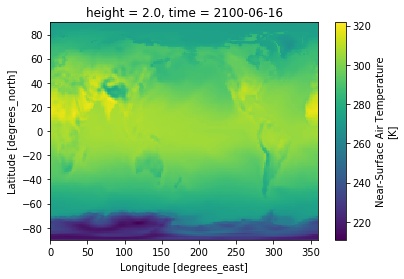

In [13]:
## Plot an example map of monthly temperature (ACCESS-CM2, June 2100)
zstore = df_cmip[(df_cmip['source_id'] == 'ACCESS-CM2') & (df_cmip['experiment_id'] == future_experiment_id)].zstore.values[0]
print(zstore)
# Create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)
# Open it using xarray and zarr
ds_future = xr.open_zarr(mapper, consolidated = True)
print(ds_future)
# Subset for time period of interest and plot
ds_future[variable_id].sel(time = '2100-06').squeeze().plot()

# Compare end of century temperature with historical period indicates increasing fire risk at higher latitudes and decreasing fire risk in sub-Saharan Africa.
Increases in temperature are most prominent at high northern latitudes (>10C rise!). 

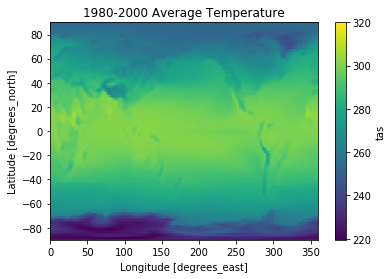

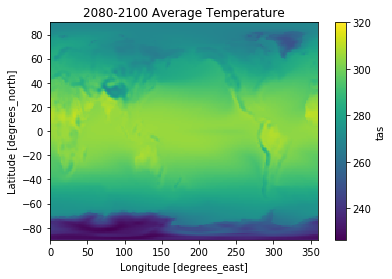

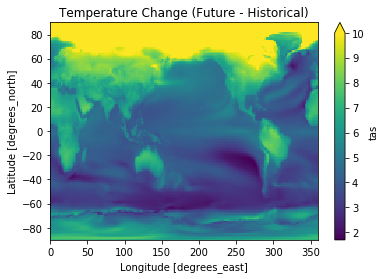

In [18]:
## Read in the matching historical data (future data already loaded above)
zstore = df_cmip[(df_cmip['source_id'] == 'ACCESS-CM2') & (df_cmip['experiment_id'] == historical_experiment_id)].zstore.values[0]
mapper = gcs.get_mapper(zstore)
ds_historical = xr.open_zarr(mapper, consolidated = True)

## Subset for time period of interest
ds_historical = ds_historical.sel(time = time_slice) 
ds_future = ds_future.sel(time = time_slice)
## Merge the historical and future datasets
ds_full = xr.concat([ds_historical, ds_future], dim = 'time')

tas_1980_2000 = ds_full[variable_id].sel(time = slice(str(1980), str(2000)))
tas_1980_2000 = tas_1980_2000.mean(dim = 'time')
tas_2080_2100 = ds_full[variable_id].sel(time = slice(str(2080), str(2100)))
tas_2080_2100 = tas_2080_2100.mean(dim = 'time')
tas_diff = tas_2080_2100 - tas_1980_2000

plt.figure(1)
tas_1980_2000.squeeze().plot(vmax = 320)
plt.title('1980-2000 Average Temperature')
plt.colorbar
plt.show()
plt.figure(2)
tas_2080_2100.squeeze().plot(vmax = 320)
plt.title('2080-2100 Average Temperature')
plt.colorbar
plt.show()
plt.figure(3)
tas_diff.squeeze().plot(vmax = 10)
plt.title('Temperature Change (Future - Historical)') #Yikes!
plt.show()

# Loop through each model to extract the annual temperature
If a model has multiple members (i.e. r1i1p1, r2i2p2, ...) take the annual mean across the model members. Computation required is roughly 70 seconds per model.

In [32]:
tas_all_models_ls = [] # Each list element will be a np array (n_assets x year) for a particular model, converted to np array afterwards
models_runs_included = []
start_time = time.time()
for model_name in model_names:
    model_members = []
    ## Loop over individual members available for a SSP. A historical member 
    ## is only included if it has a corresponding SSP member.
    n_runs_include = np.min((np.min((run_counts[model_name, future_experiment_id], run_counts[model_name, historical_experiment_id])), max_runs))
    
    for run_index in range(n_runs_include):
        print(model_name, '.r', run_index+1, 'i1p1', sep = '')
        models_runs_included.append(model_name + '.r' + str(run_index+1) + 'i1p1')

        ## Read in historical data
        zstore = df_cmip[(df_cmip['source_id'] == model_name) & (df_cmip['experiment_id'] == historical_experiment_id)].zstore.values[run_index]
        mapper = gcs.get_mapper(zstore)
        ds_historical = xr.open_zarr(mapper, consolidated = True)
        # Subset for time period of interest
        ds_historical = ds_historical.sel(time = time_slice)
        ds_historical = ds_historical.drop(['lat_bnds', 'lon_bnds', 'time_bnds'], errors = 'ignore')
  
        ## Read in future data
        zstore = df_cmip[(df_cmip['source_id'] == model_name) & (df_cmip['experiment_id'] == future_experiment_id)].zstore.values[run_index]
        mapper = gcs.get_mapper(zstore)
        ds_future = xr.open_zarr(mapper, consolidated = True)
        # Subset for time period of interest
        ds_future = ds_future.sel(time = time_slice)
        ds_future = ds_future.drop(['lat_bnds', 'lon_bnds', 'time_bnds'], errors = 'ignore')
      
        ## Merge the historical and future datasets
        ds_full = xr.concat([ds_historical, ds_future], dim = 'time')
        
        ## Rename lat/lon dim names and convert from 0,360 to -180,180 if necessary
        if ('longitude' in ds_full.dims) and ('latitude' in ds_full.dims):
            ds_full = ds_full.rename({'longitude':'lon', 'latitude': 'lat'}) 
        if (np.max(np.array(ds_full.coords['lon']))>300):
            ds_full = ds_full.assign_coords(lon = (((ds_full.lon + 180) % 360) - 180))
            ds_full = ds_full.sortby(ds_full.lon)
        if (np.max(np.array(ds_full.coords['lat']))>300):
            ds_full = ds_full.assign_coords(lat = (((ds_full.lat + 180) % 360) - 180))
            ds_full = ds_full.sortby(ds_full.lat)
              
        ## Convert from monthly to annual mean temperature
        ds_full_annual = ds_full.resample(time = 'AS', skipna = True).mean()
        
        ## Append this model's member data array to a list 
        model_members.append(ds_full_annual)
        del (zstore, mapper, ds_historical, ds_future, ds_full, ds_full_annual) 
        
    print(model_name, ' loading complete. Extracting asset location values.', sep = '')    
    
    ## Merge individual member data arrays from a model into a single array     
    ds_model_members = xr.concat(model_members, dim = 'member')

    ## Extract heatwave values at each asset's lat/lon coordinates
    # Data is lazily loaded before computation begins
    # Method = 'nearest' finds the nearest pixel to the coordinates
    tas_annual_lazy_load  = ds_model_members[variable_id].sel(
                                        lon = lons, 
                                        lat = lats, 
                                        method = 'nearest')   
    tas_annual = np.array(tas_annual_lazy_load) # Computationally heavy step
    tas_annual = np.transpose(tas_annual, (2,1,0)) # Reorder dimensions
    tas_annual.shape  # dim = n_assets x year x n_members
    
    ## Average the annual temperature across model members
    tas_annual_mean = np.nanmean(tas_annual, axis = 2) - 273.15

    ## Add the model's data to the output list
    tas_all_models_ls.append(tas_annual_mean)
    del (ds_model_members)
    end_time = time.time()
    print('Model (',len(tas_all_models_ls), '/',n_models ,') Complete. Time elapsed: ', round(end_time - start_time), ' seconds ', sep = '')    
end_time = time.time()
print('All ', len(model_names), ' models complete. Time elapsed: ', round(end_time - start_time), ' seconds ', sep = '')    

ACCESS-CM2.r1i1p1
ACCESS-CM2.r2i1p1
ACCESS-CM2.r3i1p1
ACCESS-CM2 loading complete. Extracting asset location values.
Model (1/27) Complete. Time elapsed: 65 seconds 
ACCESS-ESM1-5.r1i1p1
ACCESS-ESM1-5.r2i1p1
ACCESS-ESM1-5.r3i1p1
ACCESS-ESM1-5 loading complete. Extracting asset location values.
Model (2/27) Complete. Time elapsed: 134 seconds 
BCC-CSM2-MR.r1i1p1
BCC-CSM2-MR loading complete. Extracting asset location values.
Model (3/27) Complete. Time elapsed: 174 seconds 
CAMS-CSM1-0.r1i1p1
CAMS-CSM1-0.r2i1p1
CAMS-CSM1-0 loading complete. Extracting asset location values.
Model (4/27) Complete. Time elapsed: 244 seconds 
CESM2.r1i1p1
CESM2.r2i1p1
CESM2.r3i1p1
CESM2 loading complete. Extracting asset location values.
Model (5/27) Complete. Time elapsed: 363 seconds 
CESM2-WACCM.r1i1p1
CESM2-WACCM.r2i1p1
CESM2-WACCM.r3i1p1
CESM2-WACCM loading complete. Extracting asset location values.
Model (6/27) Complete. Time elapsed: 479 seconds 
CIESM.r1i1p1
CIESM loading complete. Extracting asse

KeyboardInterrupt: 

In [ ]:
model_members = []
    ## Loop over individual members available for a SSP. A historical member 
    ## is only included if it has a corresponding SSP member.
       # n_runs_include = np.min((np.min((run_counts[model_name, future_experiment_id], run_counts[model_name, historical_experiment_id])), max_runs))
        model_name = 'ACCESS-CM2'
        run_index = 0
   # for run_index in range(n_runs_include):
        print(model_name, '.r', run_index+1, 'i1p1', sep = '')
        models_runs_included.append(model_name + '.r' + str(run_index+1) + 'i1p1')

        ## Read in historical data
        zstore = df_cmip[(df_cmip['source_id'] == model_name) & (df_cmip['experiment_id'] == historical_experiment_id)].zstore.values[run_index]
        mapper = gcs.get_mapper(zstore)
        ds_historical = xr.open_zarr(mapper, consolidated = True)
        # Subset for time period of interest
        ds_historical = ds_historical.sel(time = time_slice)
        ds_historical = ds_historical.drop(['lat_bnds', 'lon_bnds', 'time_bnds'], errors = 'ignore')
  
        ## Read in future data
        zstore = df_cmip[(df_cmip['source_id'] == model_name) & (df_cmip['experiment_id'] == future_experiment_id)].zstore.values[run_index]
        mapper = gcs.get_mapper(zstore)
        ds_future = xr.open_zarr(mapper, consolidated = True)
        # Subset for time period of interest
        ds_future = ds_future.sel(time = time_slice)
        ds_future = ds_future.drop(['lat_bnds', 'lon_bnds', 'time_bnds'], errors = 'ignore')
      
        ## Merge the historical and future datasets
        ds_full = xr.concat([ds_historical, ds_future], dim = 'time')
        
        ## Rename lat/lon dim names and convert from 0,360 to -180,180 if necessary
        if ('longitude' in ds_full.dims) and ('latitude' in ds_full.dims):
            ds_full = ds_full.rename({'longitude':'lon', 'latitude': 'lat'}) 
        if (np.max(np.array(ds_full.coords['lon']))>300):
            ds_full = ds_full.assign_coords(lon = (((ds_full.lon + 180) % 360) - 180))
            ds_full = ds_full.sortby(ds_full.lon)
        if (np.max(np.array(ds_full.coords['lat']))>300):
            ds_full = ds_full.assign_coords(lat = (((ds_full.lat + 180) % 360) - 180))
            ds_full = ds_full.sortby(ds_full.lat)
              
        ## Convert from monthly to annual mean temperature
        ds_full_annual = ds_full.resample(time = 'AS', skipna = True).mean()
        
        ## Convert to 1deg resolution
        ds_out = xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90.5, 1.0)),
                     'lon': (['lon'], np.arange(-179.5, 180.5, 1.0))})

        regridder = xe.Regridder(ds_full_annual, ds_out, 'bilinear')
        regridder.clean_weight_file()
        #regridder
        ds_out = regridder(ds)
        print(ds_out.shape)


# Take ensemble average, estimate lower and upper uncertainty bounds 



In [48]:
## Need to convert list to np array with new dimension corresponding to model,
## but np.stack() could fail if the arrays are different sizes, which can
## happen if the end year is set to 2100 and some models extend to 2100 
## while others (CAMS-CSM1-0), frustratingly, do not (e.g. ending at 12/2099)
## IF so, fix by appending the value from 2099 as that model's value for 2100
n_years = end_year - start_year + 1
print(n_years)
for model_idx, model_data in enumerate(tas_all_models_ls):
    print(model_data.shape)
    if (model_data.shape[1] == (n_years-1)):
        col_idx_duplicate = n_years - 2 # Year column index you want to copy over as new column
        tas_2099 = tas_all_models_ls[model_idx][:,col_idx_duplicate][...,None]
        tas_all_models_ls[model_idx] = np.concatenate((tas_all_models_ls[model_idx], tas_2099), 1) # CAMS-CSM1-0 ends in 2099

121
(2494, 121)
(2494, 121)
(2494, 121)
(2494, 121)
(2494, 121)
(2494, 121)
(2494, 121)
(2494, 121)


In [ ]:
tas_all_models = np.transpose(np.stack(tas_all_models_ls, axis = 0), (1,2,0))
print(tas_all_models.shape)  # dim = n_assets x year x n_models
tas_all_models_xr = xr.DataArray(tas_all_models, dims = ['asset_index', 'year', 'model_name'],
                                 coords = {'year': np.array(range(start_year, end_year+1)), 
                                           'model_name': model_names})
tas_all_models_xr.to_netcdf(BASE_DATA_FOLDER + 'sust/sustglobal_asset_fwd_temperature_risk_'+ ENTITY_NAME + '_' + future_experiment_id + '.nc')

tas_ensemble_average = np.nanmean(tas_all_models, axis = 2)
tas_ensemble_average_lbd = np.nanquantile(tas_all_models, q = q_lbd, axis = 2)
tas_ensemble_average_ubd = np.nanquantile(tas_all_models, q = q_ubd, axis = 2)

# Export the ensemble average dataset to CSV
Export the raw (unscaled) data.

In [78]:
tas_out = pd.concat([df_asset, pd.DataFrame(tas_ensemble_average, columns = range(start_year, end_year+1))], axis = 1)
tas_out.to_csv(BASE_DATA_FOLDER + 'sust/sustglobal_asset_fwd_temperature_risk_'+ ENTITY_NAME + '_' + future_experiment_id + '.csv', index = False)

tas_lbd_out = pd.concat([df_asset, pd.DataFrame(tas_ensemble_average_lbd, columns = range(start_year, end_year+1))], axis = 1)
tas_lbd_out.to_csv(BASE_DATA_FOLDER + 'sust/sustglobal_asset_fwd_temperature_risk_'+ ENTITY_NAME + '_' + future_experiment_id + '_lbd.csv', index = False)

tas_ubd_out = pd.concat([df_asset, pd.DataFrame(tas_ensemble_average_ubd, columns = range(start_year, end_year+1))], axis = 1)
tas_ubd_out.to_csv(BASE_DATA_FOLDER + 'sust/sustglobal_asset_fwd_temperature_risk_'+ ENTITY_NAME + '_' + future_experiment_id + '_ubd.csv', index = False)

In [ ]:
## Save text file with the model/runs used 
print(models_runs_included)
with open(BASE_DATA_FOLDER + 'sust/sustglobal_asset_fwd_temperature_risk_'+ ENTITY_NAME + '_' + future_experiment_id + '_models.txt', 'w') as f:
    for item in models_runs_included:
        f.write("%s\n" % item)